In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import optax
from flax import nnx
import orbax.checkpoint as ocp

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt
from jax.experimental.ode import odeint

import jaxpm
from jaxpm.painting import cic_paint, cic_read
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces, make_ode_fn_diffrax, make_ode_fn
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel

from jaxpm.nn import MLP
from jaxpm import camels, plotting, hpm, nn

jax.devices("gpu")

[cuda(id=0)]

# configuration

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

In [4]:
# def plot_particle_evolution(scales, positions, weights=None):
#     ncols = 4
#     nrows = len(scales) // ncols
#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols,2*nrows))
    
#     i = 0
#     for j in range(nrows):
#         for k in range(ncols):
#             im = ax[j,k].imshow(
#                 cic_paint(jnp.zeros(mesh_shape), dm_poss[i]).sum(axis=0), 
#                 cmap='gist_stern',
#                 vmin=0,
#                 # vmax=cic_paint(jnp.zeros(mesh_shape), pos_i).sum(axis=0).max(),
#             )
    
#             ax[j,k].set(title=f"{scales[i]:.4f}")
#             ax[j,k].set_xticks([])
#             ax[j,k].set_yticks([])
    
#             i += 1

# CAMELS

In [5]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"

out_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    # i_snapshots=[-2, -1],
    # i_snapshots=range(0, 32, 4),
    # i_snapshots=range(0, 32, 8),
    i_snapshots=range(1, 33+4, 4),
    return_hydro=True,
)

cosmo = out_dict["cosmo"]
scales = out_dict["scales"]

dm_poss = out_dict["dm_poss"]
dm_vels = out_dict["dm_vels"]

gas_poss = out_dict["gas_poss"]
gas_vels = out_dict["gas_vels"]

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_018.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_034.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_042.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_050.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_058.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_066.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_074.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_082.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 9/9 [01:31<00:00, 10.19s/it]


In [6]:
# plotting.plot_particle_evolution(mesh_shape, scales, dm_poss, title="dark matter")
# plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, title="gas")

# @partial(jax.vmap, in_axes=(0, 0))
# def normalize_field(field_pos, pos):
#     rho_pos = cic_read(cic_paint(jnp.zeros(mesh_shape), pos), pos)
#     return field_pos / rho_pos

# gas_Ps = normalize_field(out_dict["gas_Ps"], gas_poss)
# plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, gas_Ps, title="pressure")

# gas_Ts = normalize_field(out_dict["gas_Ts"], gas_poss)
# plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, gas_Ts, title="temperature")

In [7]:
# fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# im0 = ax[0].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), dm_pos).sum(axis=0)), cmap='magma')
# ax[0].set(title='Hydro DM')
# fig.colorbar(im0, ax=ax[0])

# im1 = ax[1].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), gas_pos).sum(axis=0)), cmap='magma')
# ax[1].set(title='Hydro Gas')
# fig.colorbar(im1, ax=ax[1])

# # im2 = ax[2].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos, hydro_gas_P/hydro_gas_rho).sum(axis=0)), cmap='magma')
# # ax[2].set(title='Hydro Gas Pressure')
# # fig.colorbar(im2, ax=ax[2])

# # im3 = ax[3].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos, hydro_gas_T/hydro_gas_rho).sum(axis=0)), cmap='magma')
# # ax[3].set(title='Hydro Gas Temperature')
# # fig.colorbar(im3, ax=ax[3])

# fig.tight_layout()

# reference simulation

In [8]:
# @partial(jax.jit, static_argnums=[3, 4, 5, 6])
# def run_pm(scales, dm_pos_i, dm_vel_i, cosmo, checkpoints=5, rtol=1e-5, atol=1e-5):
#     print("tracing the simulation")
        
#     res = diffeqsolve(
#         terms=ODETerm(make_ode_fn_diffrax(cosmo, mesh_shape)),
#         solver=Dopri5(),
#         t0=scales[0],
#         t1=scales[-1],
#         dt0=0.05,
#         y0=jnp.stack([dm_pos_i, dm_vel_i], axis=0),
#         saveat=SaveAt(ts=scales),
#         adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints),
#         max_steps=1000,
#         stepsize_controller=PIDController(rtol=rtol, atol=atol),
#     )

#     return res.ys[:,0], res.ys[:,1]

In [9]:
# pm_dm_poss, pm_dm_vels = run_pm(
#     scales,
#     dm_poss[0], 
#     dm_vels[0], 
#     cosmo
# )

# # plotting.plot_particle_evolution(mesh_shape, scales, dm_poss, title="dark matter (pm)")

In [10]:
resi = odeint(make_ode_fn(mesh_shape), [dm_poss[0], dm_vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

pm_dm_poss = resi[0]
pm_dm_vels = resi[1]

In [11]:
# plotting.plot_particle_comparison(
#     mesh_shape, 
#     scales, 
#     jnp.stack([dm_poss, jnp.stack(resi[0])]), 
#     title="dark matter",
#     col_titles=["CAMELS", "pm"],
#     include_pk=True,
# )

# HPM simulation

In [12]:
model = MLP(
    d_in=3, 
    d_out=2, 
    d_hidden=512, 
    n_hidden=4, 
    rngs=nnx.Rngs(0)
)

abstract_model = nnx.eval_shape(lambda: model)
graphdef, abstract_params = nnx.split(abstract_model)

checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp.jx")
checkpointer = ocp.StandardCheckpointer()
params = checkpointer.restore(checkpoint_file, abstract_params)
model = nnx.merge(graphdef, params)

/cluster/home/athomsen/flatiron/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


# HPM network

In [13]:
@partial(jax.vmap, in_axes=(0, 0, 0))
def predict_P(scale, dm_pos, gas_pos):
    kvec = fftk(mesh_shape)
    
    delta_dm = cic_paint(jnp.zeros(mesh_shape), dm_pos)
    delta_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, weight=cosmo.Omega_b / cosmo.Omega_c)
    delta_tot = delta_dm + delta_gas

    gas_delta_tot = cic_read(delta_tot, gas_pos)

    delta_k = jnp.fft.rfftn(delta_tot)
    gas_fscalar = cic_read(jnp.fft.irfftn(delta_k * invnabla_kernel(kvec)), gas_pos)
    
    gas_inputs = jnp.stack(
        [jnp.tile(scale, gas_delta_tot.shape[0]), jnp.log10(gas_delta_tot), jnp.arcsinh(gas_fscalar / 100)], axis=-1
    )
    
    # gas_preds = model(gas_inputs)
    print(gas_inputs.shape)
    gas_preds = nn.batched_eval(model, gas_inputs, 10_000)
    
    gas_P, gas_T = 10 ** gas_preds[:, 0], 10 ** gas_preds[:, 1]

    return gas_P


(262144, 3)


100%|██████████| 26/26 [00:00<00:00, 45.01it/s]


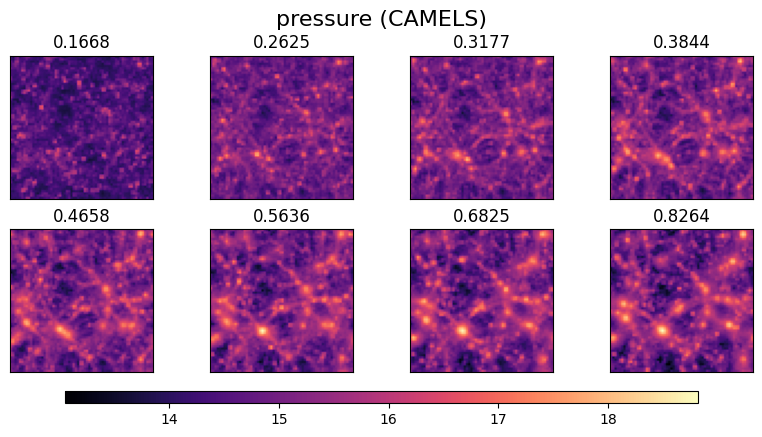

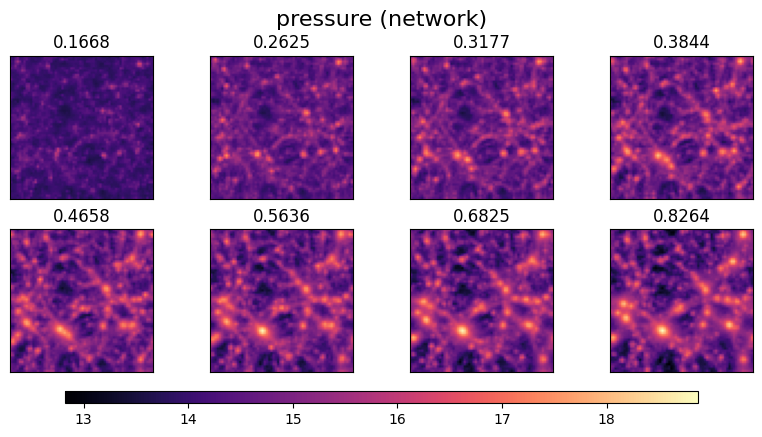

In [14]:
@partial(jax.vmap, in_axes=(0, 0))
def normalize_field(field_pos, pos):
    rho_pos = cic_read(cic_paint(jnp.zeros(mesh_shape), pos), pos)
    return field_pos / rho_pos

gas_Ps_camels = normalize_field(out_dict["gas_Ps"], gas_poss)
plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, gas_Ps_camels, title="pressure (CAMELS)")

gas_Ps_preds = normalize_field(predict_P(scales, dm_poss, gas_poss), gas_poss)
plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, gas_Ps_preds, title="pressure (network)")


In [15]:
hpm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint")

res = odeint(hpm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-3, atol=1e-3)
hpm_dm_poss, hpm_dm_vels, hpm_gas_poss, hpm_gas_vels = res[0], res[1], res[2], res[3]

In [27]:
pm_ode = hpm.get_hpm_network_ode_fn(model, mesh_shape, cosmo, "odeint", gravity_only=True)

res = odeint(pm_ode, [dm_poss[0], dm_vels[0], gas_poss[0], gas_vels[0]], scales, rtol=1e-3, atol=1e-3)
pm_dm_poss, pm_dm_vels, pm_gas_poss, pm_gas_vels = res[0], res[1], res[2], res[3]

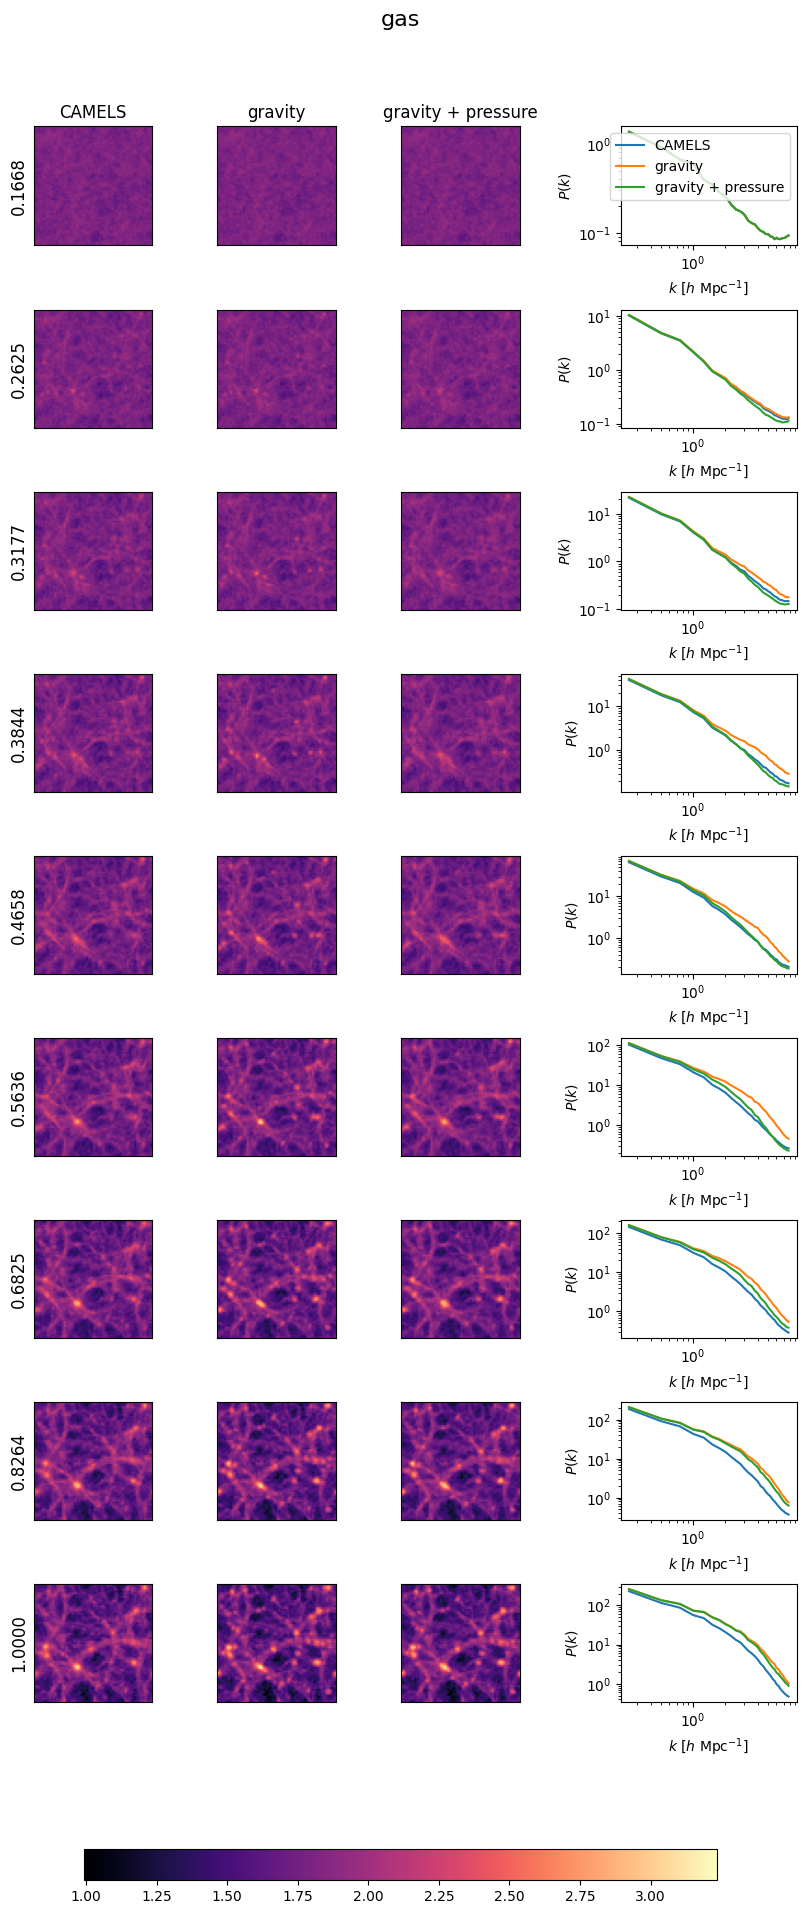

In [32]:
plotting.compare_particle_evolution(
    mesh_shape, 
    scales, 
    jnp.stack([gas_poss, pm_gas_poss, hpm_gas_poss], axis=0), 
    title="gas",
    col_titles=["CAMELS", "gravity", "gravity + pressure"],
    include_pk=True,
)

In [17]:
# # @partial(jax.jit, static_argnums=[5, 6, 7, 8])
# # @partial(nnx.jit, static_argnums=[5, 6, 7, 8])
# def run_hpm(scales, dm_pos_i, dm_vel_i, gas_pos_i, gas_vel_i, cosmo, checkpoints=5, rtol=1e-3, atol=1e-3):
#     print("tracing the simulation")

#     res = diffeqsolve(
#         terms=ODETerm(hpm_ode),
#         solver=Dopri5(),
#         t0=scales[0],
#         t1=scales[-1],
#         dt0=0.01,
#         y0=jnp.stack([dm_pos_i, dm_vel_i, gas_pos_i, gas_vel_i], axis=0),
#         saveat=SaveAt(ts=scales),
#         adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints),
#         max_steps=100,
#         stepsize_controller=PIDController(rtol=rtol, atol=atol),
#     )

#     return res.ys[:,0], res.ys[:,1], res.ys[:,2], res.ys[:,3]

In [18]:
# vmin, vmax = plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, title="gas (CAMELS)", return_lims=True)
# plotting.plot_particle_evolution(mesh_shape, scales, hpm_gas_poss, title="gas (hpm)", vmin=vmin, vmax=vmax)

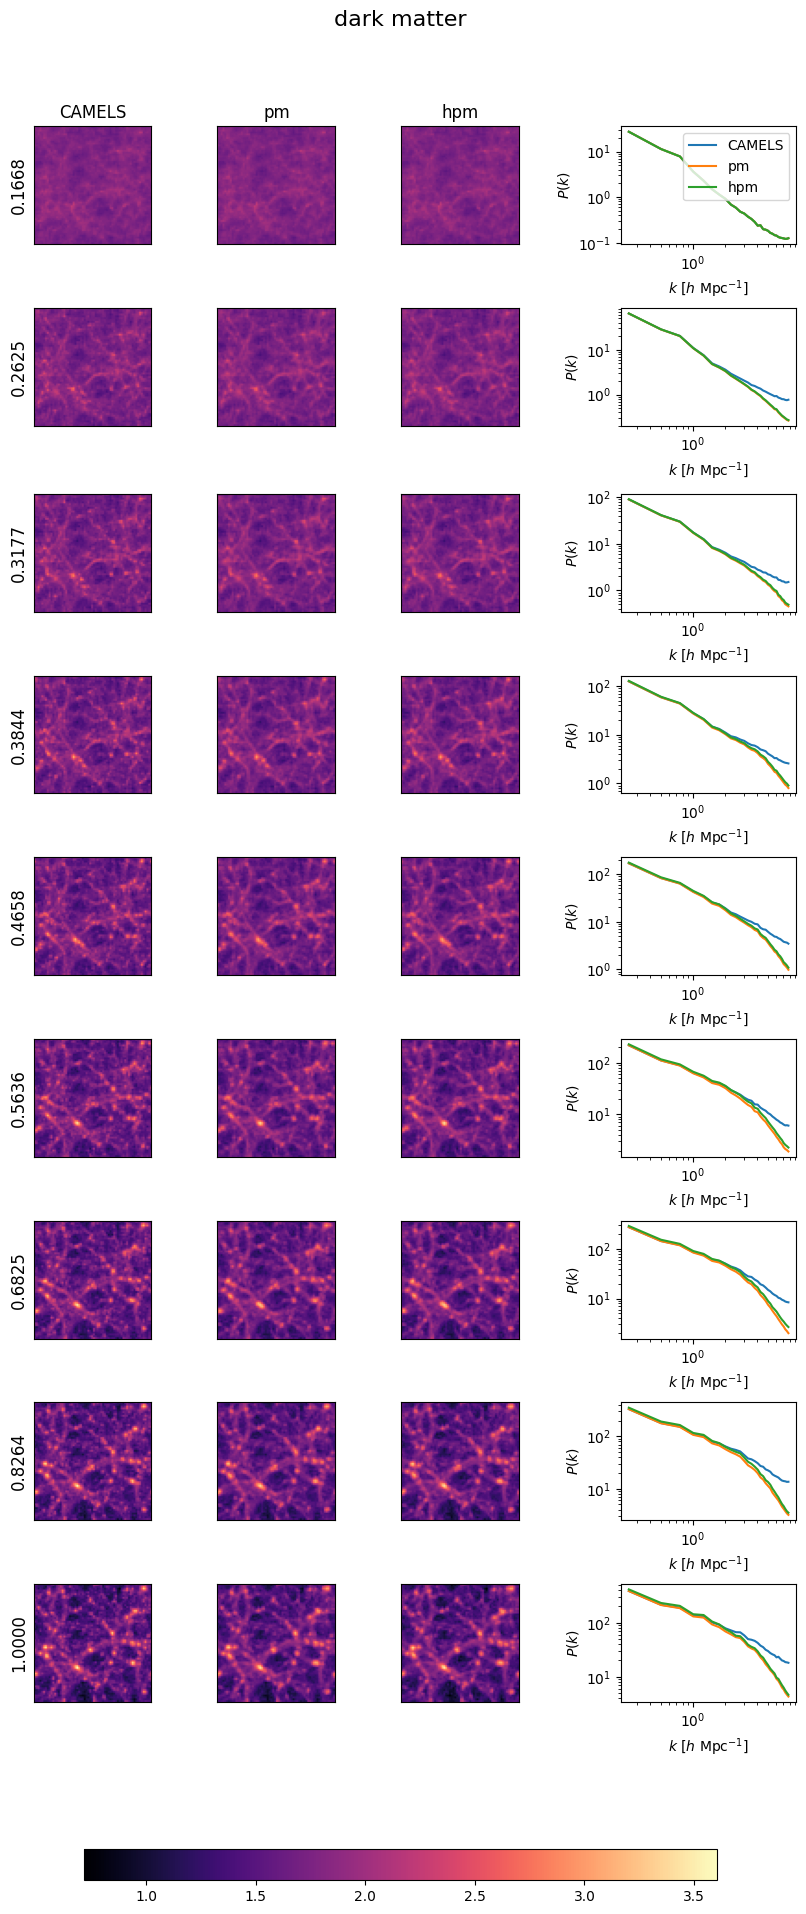

In [19]:
plotting.compare_particle_evolution(
    mesh_shape, 
    scales, 
    jnp.stack([dm_poss, pm_dm_poss, hpm_dm_poss], axis=0), 
    title="dark matter",
    col_titles=["CAMELS", "pm", "hpm"],
    include_pk=True,
)

In [20]:
# vmin, vmax = plotting.plot_particle_evolution(mesh_shape, scales, dm_poss, title="dark matter (CAMELS)", return_lims=True)
# plotting.plot_particle_evolution(mesh_shape, scales, pm_dm_poss, title="dark matter (pm)", vmin=vmin, vmax=vmax)
# plotting.plot_particle_evolution(mesh_shape, scales, hpm_dm_poss, title="dark matter (hpm)", vmin=vmin, vmax=vmax)

[autoreload of jaxpm.hpm failed: Traceback (most recent call last):
  File "/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/cluster/home/a

In [21]:
# def paint_log_sum(positions, weights=None):
#     return np.log10(cic_paint(jnp.zeros(mesh_shape), positions, weights).sum(axis=0))

# i_scale = -1

# nrows = 2
# ncols = 3
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

# # dark matter
# dm_field = paint_log_sum(dm_poss[i_scale])
# vmin, vmax = dm_field.min(), dm_field.max()
# im0 = ax[0,0].imshow(dm_field, vmin=vmin, vmax=vmax)
# im2 = ax[0,1].imshow(paint_log_sum(hpm_dm_poss[i_scale]), vmin=vmin, vmax=vmax)
# im1 = ax[0,2].imshow(paint_log_sum(ref_dm_poss[i_scale]), vmin=vmin, vmax=vmax)

# ax[0,0].set_ylabel("dark matter", fontsize=24)
# ax[0,0].set_title("CAMELS", fontsize=24)
# ax[0,1].set_title("hydro particle mesh", fontsize=24)
# ax[0,2].set_title("particle mesh", fontsize=24)
# cbar = fig.colorbar(im0, ax=ax[0, :], orientation='horizontal', pad=0.05, aspect=50, shrink=0.8)

# # gas
# im0 = ax[1,0].imshow(paint_log_sum(gas_poss[i_scale]))
# im1 = ax[1,1].imshow(paint_log_sum(hpm_gas_poss[i_scale]))
# ax[1,2].axis("off")

# ax[1,0].set_ylabel("gas", fontsize=24)
# cbar = fig.colorbar(im0, ax=ax[1, :], orientation='horizontal', pad=0.05, aspect=50, shrink=0.8)

# # pressure

# # temperature

# for i in range(nrows):
#     for j in range(ncols):
#         ax[i,j].set_xticks([])
#         ax[i,j].set_yticks([])




# Network (scale, rho, fscalar -> P, T)

In [22]:
# @partial(jax.vmap, in_axes=(0, 0, 0))
# def predict_P(scale, dm_pos, gas_pos):
#     kvec = fftk(mesh_shape)
    
#     delta_dm = cic_paint(jnp.zeros(mesh_shape), dm_pos)
#     delta_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, weight=cosmo.Omega_b / cosmo.Omega_c)
#     delta_tot = delta_dm + delta_gas

#     gas_delta_tot = cic_read(delta_tot, gas_pos)

#     delta_k = jnp.fft.rfftn(delta_tot)
#     gas_fscalar = cic_read(jnp.fft.irfftn(delta_k * invnabla_kernel(kvec)), gas_pos)
    
#     gas_inputs = jnp.stack(
#         [jnp.tile(scale, gas_delta_tot.shape[0]), jnp.log10(gas_delta_tot), jnp.arcsinh(gas_fscalar / 100)], axis=-1
#     )
#     gas_preds = model(gas_inputs)
#     gas_P, gas_T = 10 ** gas_preds[:, 0], 10 ** gas_preds[:, 1]

#     return gas_P


In [23]:
# @partial(jax.vmap, in_axes=(0, 0))
# def normalize_field(field_pos, pos):
#     rho_pos = cic_read(cic_paint(jnp.zeros(mesh_shape), pos), pos)
#     return field_pos / rho_pos

# gas_Ps_camels = normalize_field(out_dict["gas_Ps"], gas_poss)
# plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, gas_Ps_camels, title="pressure (CAMELS)")

# gas_Ps_preds = normalize_field(predict_P(scales, dm_poss, gas_poss), gas_poss)
# plotting.plot_particle_evolution(mesh_shape, scales, gas_poss, gas_Ps_preds, title="pressure (network)")


In [24]:
# scale = scales[-1]
# dm_pos = dm_poss[-1]
# gas_pos = gas_poss[-1]

# kvec = fftk(mesh_shape)

# rho_dm = cic_paint(jnp.zeros(mesh_shape), dm_pos)
# rho_gas = cic_paint(jnp.zeros(mesh_shape), gas_pos, weight=cosmo.Omega_b / cosmo.Omega_c)
# rho_tot = rho_dm + rho_gas

# gas_rho_tot = cic_read(rho_tot, gas_pos)

# rho_tot_k = jnp.fft.rfftn(rho_tot)
# gas_fscalar = cic_read(jnp.fft.irfftn(rho_tot_k * invnabla_kernel(kvec)), gas_pos)

# gas_inputs = jnp.stack(
#     [jnp.tile(scale, gas_pos.shape[0]), jnp.log10(gas_rho_tot), jnp.arcsinh(gas_fscalar / 100)], axis=-1
# )


In [25]:
# def compute_stats(array):
#     stats = {
#         "mean": np.mean(array),
#         "min": np.min(array),
#         "max": np.max(array),
#         "std": np.std(array),
#     }
    
#     for key, value in stats.items():
#         print(key, f"{value:.2f}")